# DBSCAN

In [102]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from util.model_eval import evaluate_clustering
from util.visualize_clusters import visualize_clusters
import seaborn as sns


In [90]:
df = pd.read_csv('../prepared_data.csv')
features = df.drop(columns='Node')
features.head()

,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,EigenvectorCentrality,Eccentricity,Constraint,MeanNeighborDegree,LocalClusterSizes,LocalClusterDensities,sorensen_indices,participation_coefficient,CommunitySize,CommunityDensity,CommunityAssortativity
0,0.700547,0.419118,-0.057036,0.261376,1.000118,0.000006,1.043499,1.048030,-1.206914,-1.187895,0.047468,0.128317,1.078821,-0.849481,0.042446,-0.133841
1,0.597675,0.888889,-0.057268,0.261258,1.000100,0.000002,1.043499,1.100383,-1.206914,-1.187895,0.047468,0.122203,1.073933,-0.849481,0.042446,-0.133841
2,0.700547,0.632353,-0.057130,0.261376,1.000113,0.000007,1.043499,1.048897,-1.206914,-1.187895,0.047468,0.143140,1.078447,-0.849481,0.042446,-0.133841
3,0.597675,0.866667,-0.057259,0.261258,1.000116,0.000002,1.043499,1.149038,-1.206914,-1.187895,0.047468,0.110459,1.074068,-0.849481,0.042446,-0.133841
4,0.643779,0.333333,-0.057085,0.261308,1.000101,0.000012,1.043499,1.056431,-1.206914,-1.187895,0.047468,0.119667,1.076862,-0.849481,0.042446,-0.133841


In [91]:
features.isnull().sum()

Degree                        0
ClusteringCoefficient         0
BetweennessCentrality         0
ClosenessCentrality           0
PageRank                      0
EigenvectorCentrality         0
Eccentricity                  0
Constraint                    0
MeanNeighborDegree            0
LocalClusterSizes             0
LocalClusterDensities         0
sorensen_indices              0
participation_coefficient    29
CommunitySize                 0
CommunityDensity              0
CommunityAssortativity        0
dtype: int64

Imputing missing values with the feature's median

In [92]:
imputer = SimpleImputer(strategy="median")
features[['participation_coefficient']] = imputer.fit_transform(features[['participation_coefficient']])
features.isnull().sum()

Degree                       0
ClusteringCoefficient        0
BetweennessCentrality        0
ClosenessCentrality          0
PageRank                     0
EigenvectorCentrality        0
Eccentricity                 0
Constraint                   0
MeanNeighborDegree           0
LocalClusterSizes            0
LocalClusterDensities        0
sorensen_indices             0
participation_coefficient    0
CommunitySize                0
CommunityDensity             0
CommunityAssortativity       0
dtype: int64

## Find best parameters for DBSCAN model

Loop through a range of values for eps and min_samples to find the best set of parameters. Each model is evaluated based on silhouette score(full data, not sampled), davies_bouldin_score, and calinski_harabasz_score.

Based on this parameter evaluation I'll use the values of 0.8 for eps and 7 for min_samples. This achieved the highest silhouette score of 0.649 and it was the same for min_samples=5-9, indicating stability for this eps. It also had very low noise with only 16 data points not clustered. The high Calinski-Harabasz score also indicates good distance between clusters relative to within-cluster variance.

In [94]:
eps_values = np.arange(0.2, 3.0, 0.2)
min_samples_values = range(3, 10)
# Run evaluation for each parameter set
results_list = []
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(features)
        eval_result = evaluate_clustering(features, labels, show_plot=False)
        eval_result["eps"] = eps
        eval_result["min_samples"] = min_samples
        results_list.append(eval_result)

# Create and show the results DataFrame
results_df = pd.DataFrame(results_list)

In [95]:
max_silhouette = results_df["silhouette_score"].max()
best_rows = results_df[results_df["silhouette_score"] == max_silhouette]
best_rows

,n_clusters,n_noise,silhouette_score,davies_bouldin_score,calinski_harabasz_score,eps,min_samples
23,11,16,0.64901,1.266093,5174.296493,0.8,5
24,11,16,0.64901,1.266093,5174.296493,0.8,6
25,11,16,0.64901,1.266093,5174.296493,0.8,7
26,11,16,0.64901,1.266093,5174.296493,0.8,8
27,11,16,0.64901,1.266093,5174.296493,0.8,9


Train the model with the best scores

In [96]:
db = DBSCAN(eps=0.8, min_samples=7)
labels = db.fit_predict(features)
features["Cluster"] = labels

## Cluster evaluation

Checking the distribution of cluster sizes, these are the things to note:

* Cluster 5 is the largest with 900 members. This cluster represents the most common node profile
* Clusters 3,4,10 are very small in comparison to all others. These may be the edge cases or bridges

In [97]:
features["Cluster"].value_counts().sort_index()

Cluster
-1      16
 0     368
 1     541
 2     213
 3      38
 4      44
 5     900
 6     124
 7     527
 8     512
 9     226
 10     23
Name: count, dtype: int64

Computing the means of each value for each cluster, as well as the difference from the global average to see where each cluster stands out.

The notable clusters in these numbers are cluster -1 (noise) and cluster 3

Cluster -1 (Noise)

* Very high betweenness centrality — they act as bridges in the network.
* Low local density — not part of any tightly-knit group.
* Close to others in the network (low eccentricity), just not densely surrounded.
* Labeled as noise, but still seem structurally important. Perhaps they are important bridges or hubs?

Cluster 3

* High degree and closeness indicates they’re popular and central.
* Found in large communities, and close to everyone in the network.
* Low clustering coefficient means their neighbors aren’t tightly connected.
* Overall, small in size, but very well-connected. These seem to have wide spread influence



In [100]:
cluster_summary = features.groupby("Cluster").mean().round(3)
cluster_summary

,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,EigenvectorCentrality,Eccentricity,Constraint,MeanNeighborDegree,LocalClusterSizes,LocalClusterDensities,sorensen_indices,participation_coefficient,CommunitySize,CommunityDensity,CommunityAssortativity
Cluster,,,,,,,,,,,,,,,,
-1,0.737,0.613,0.348,0.289,1.0,0.003,-0.875,1.102,-0.273,0.128,0.058,0.088,1.028,-0.264,0.040,-0.091
0,0.677,0.676,-0.045,0.255,1.0,0.000,1.043,1.100,-1.198,-1.276,0.060,0.143,1.059,-0.945,0.051,-0.132
1,0.703,0.644,-0.052,0.243,1.0,0.000,-0.572,1.081,-1.059,-0.564,0.038,0.103,1.039,-0.269,0.036,-0.094
2,0.740,0.652,-0.055,0.277,1.0,0.000,-0.572,1.069,-0.634,-1.377,0.109,0.130,1.076,0.673,0.040,-0.070
3,0.931,0.458,0.017,0.343,1.0,0.000,-2.187,1.036,0.355,1.372,0.045,0.058,1.071,1.107,0.050,0.083
4,1.068,0.540,-0.033,0.305,1.0,0.000,-2.187,1.027,-0.567,-0.847,0.072,0.144,1.080,0.673,0.040,-0.070
5,1.031,0.575,-0.053,0.319,1.0,0.000,-0.572,1.039,0.443,1.158,0.049,0.084,1.044,0.926,0.046,0.019
6,0.661,0.662,-0.057,0.178,1.0,0.000,2.659,1.084,-0.987,-1.752,0.124,0.174,1.077,-1.419,0.094,-0.114
7,1.003,0.625,-0.052,0.268,1.0,0.029,1.043,1.042,1.667,0.179,0.104,0.095,1.057,-0.263,0.093,0.016


In [101]:
global_means = features.drop(columns=["Cluster"]).mean()
cluster_deltas = cluster_summary.subtract(global_means).round(3)
cluster_deltas

,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,EigenvectorCentrality,Eccentricity,Constraint,MeanNeighborDegree,LocalClusterSizes,LocalClusterDensities,sorensen_indices,participation_coefficient,CommunitySize,CommunityDensity,CommunityAssortativity
Cluster,,,,,,,,,,,,,,,,
-1,-0.140,0.011,0.398,0.012,-0.0,-0.001,-0.808,0.044,-0.204,0.126,-0.005,-0.015,-0.024,-0.412,-0.026,-0.086
0,-0.200,0.074,0.005,-0.022,-0.0,-0.004,1.110,0.042,-1.129,-1.278,-0.003,0.040,0.007,-1.093,-0.015,-0.127
1,-0.174,0.042,-0.002,-0.034,-0.0,-0.004,-0.505,0.023,-0.990,-0.566,-0.025,-0.000,-0.013,-0.417,-0.030,-0.089
2,-0.137,0.050,-0.005,-0.000,-0.0,-0.004,-0.505,0.011,-0.565,-1.379,0.046,0.027,0.024,0.525,-0.026,-0.065
3,0.054,-0.144,0.067,0.066,-0.0,-0.004,-2.120,-0.022,0.424,1.370,-0.018,-0.045,0.019,0.959,-0.016,0.088
4,0.191,-0.062,0.017,0.028,-0.0,-0.004,-2.120,-0.031,-0.498,-0.849,0.009,0.041,0.028,0.525,-0.026,-0.065
5,0.154,-0.027,-0.003,0.042,-0.0,-0.004,-0.505,-0.019,0.512,1.156,-0.014,-0.019,-0.008,0.778,-0.020,0.024
6,-0.216,0.060,-0.007,-0.099,-0.0,-0.004,2.726,0.026,-0.918,-1.754,0.061,0.071,0.025,-1.567,0.028,-0.109
7,0.126,0.023,-0.002,-0.009,-0.0,0.025,1.110,-0.016,1.736,0.177,0.041,-0.008,0.005,-0.411,0.027,0.021


Cluster -1 (Noise)

* Labeled as noise, but still structurally important.
* Very high betweenness centrality — they act as bridges in the network.
* Low local density — not part of any tightly-knit group.
* Close to others in the network (low eccentricity), just not densely surrounded.


🟩 Cluster 3 – The Super-Connectors

Small in size, but very well-connected.

High degree and closeness — they’re popular and central.

Low clustering coefficient — their neighbors aren’t tightly connected.

Found in large communities, acting as structural glue.

👉 These are the backbone nodes holding major parts of the graph together.

<Figure size 1400x500 with 0 Axes>

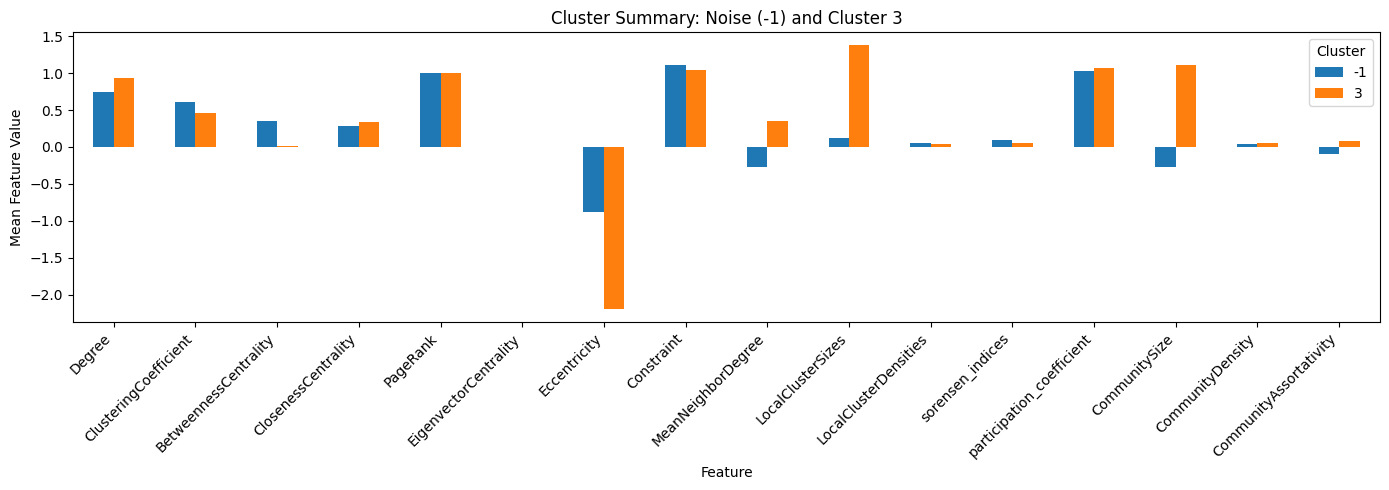

<Figure size 1400x500 with 0 Axes>

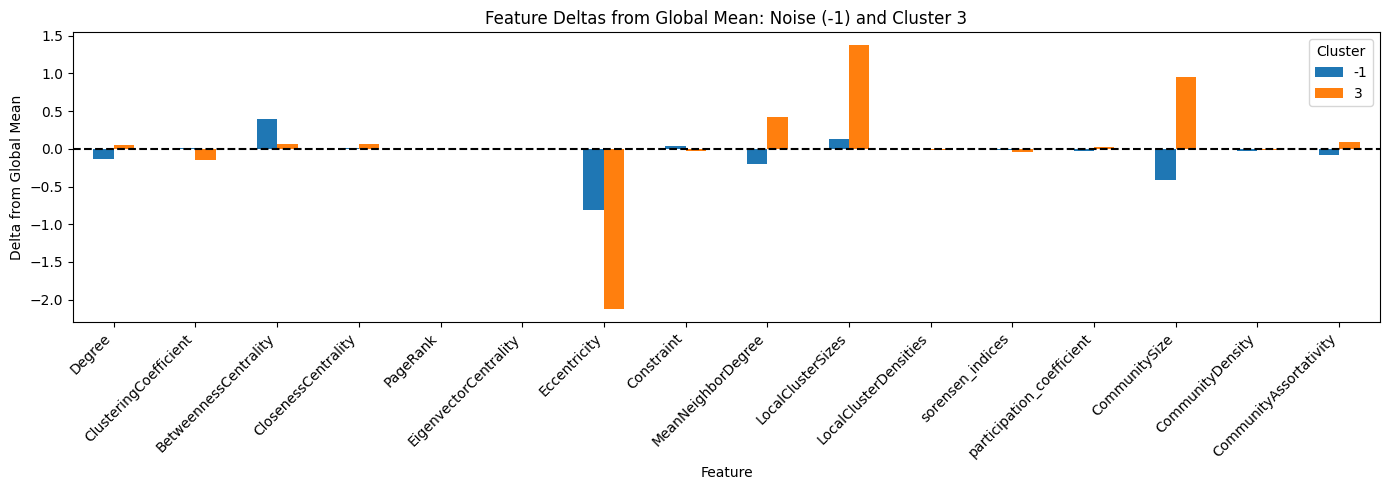

In [107]:
# Filter the summary data for clusters -1 and 3
cluster_summary_subset = cluster_summary.loc[[-1, 3]]
cluster_deltas_subset = cluster_deltas.loc[[-1, 3]]

# Bar plot for summary values
plt.figure(figsize=(14, 5))
cluster_summary_subset.T.plot(kind='bar', figsize=(14, 5))
plt.title("Cluster Summary: Noise (-1) and Cluster 3")
plt.ylabel("Mean Feature Value")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Bar plot for deltas from mean
plt.figure(figsize=(14, 5))
cluster_deltas_subset.T.plot(kind='bar', figsize=(14, 5))
plt.title("Feature Deltas from Global Mean: Noise (-1) and Cluster 3")
plt.ylabel("Delta from Global Mean")
plt.xlabel("Feature")
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()